# Домашнее задание №1 - Метод К-ближайших соседей (K-nearest neighbors)

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

Зафиксируем рандом:

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании работаем с картинками одежды, среди которых можно выделить 10 классов. В переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Возьмем случайно 1000 наблюдений.

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

/home/golofeevad/mambaforge/envs/pythonProject1/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


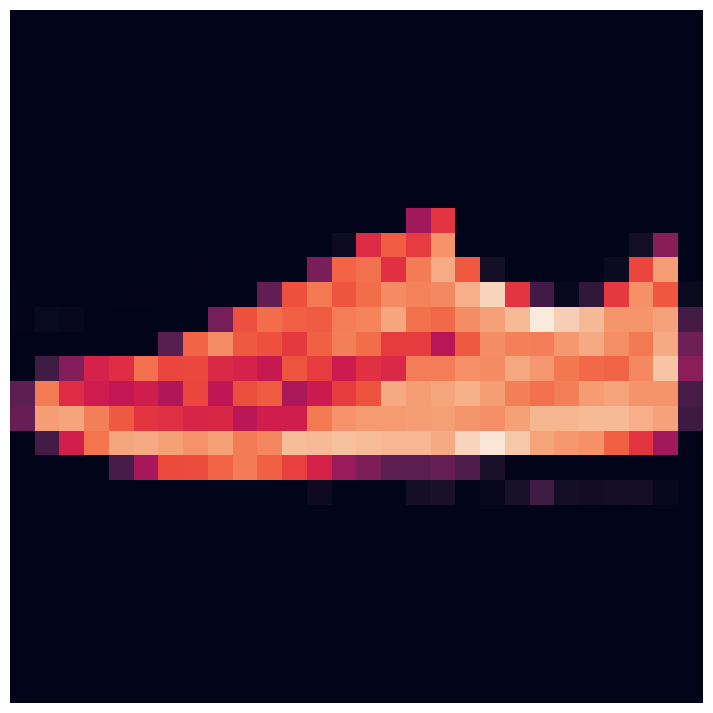

In [4]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

Получили шакальный тапок)

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

Сначала найдём индексы картинок разных классов:

In [5]:
unique_classes = np.unique(y, return_index=True)
unique_classes

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([ 2,  5,  8,  3, 34,  0, 18, 22, 13,  1]))

In [6]:
unique_raws_indexes = unique_classes[1]

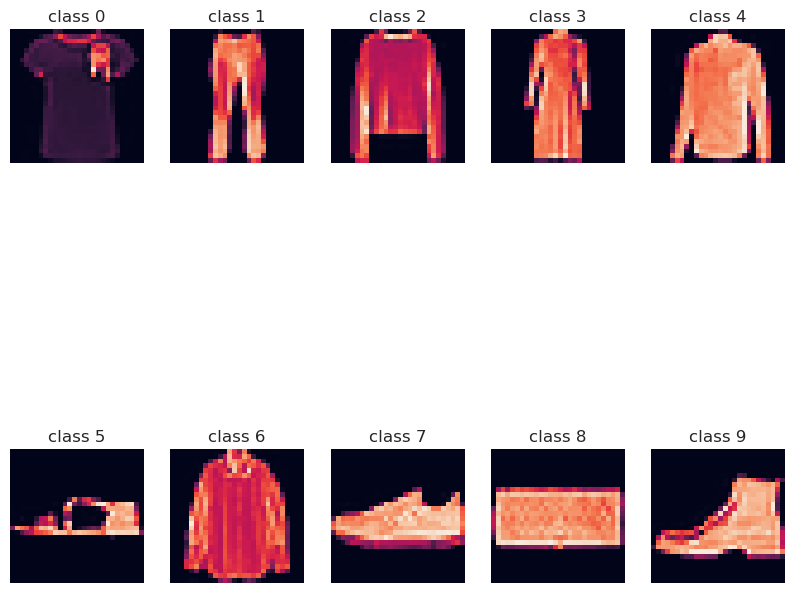

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(10, 10))
for ax, mark in zip(axs.flat, unique_raws_indexes):
    ax.set_title(f'class {y[mark]}')
    ax.imshow(X[mark].reshape(28, 28, 1))
    ax.axis("off")

### 1.2. Сделайте небольшой EDA (1 балл)
Посмотрим на баланс классов.

[Text(0.5, 0, 'Class')]

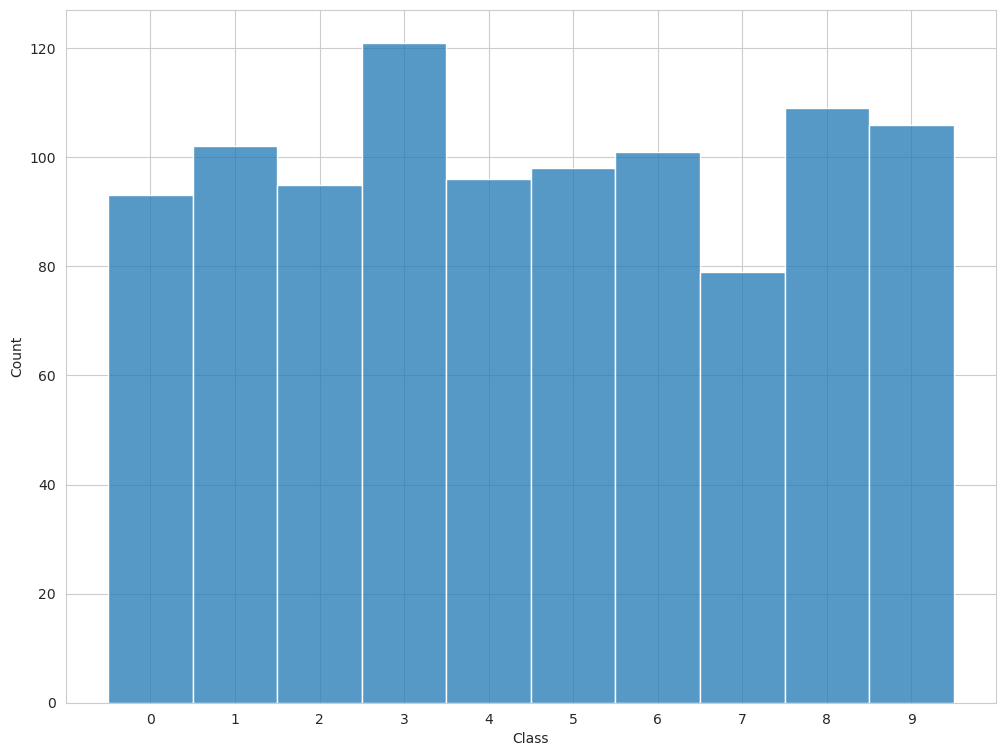

In [8]:
sns.histplot(sorted(y)).set(xlabel='Class')

Ну, видимо, больше всего картинок платьев

### 1.3. Разделите данные на train и test (0.5 баллов)

Нуууу пусть модель поучится на 0.9 доле данных

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    test_size=0.1)

### 1.4. KNN для бинарной классификации (6 баллов)


Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [10]:
bin_indexes_train = np.where((y_train=='0') | (y_train=='1'))
bin_indexes_test = np.where((y_test=='0') | (y_test=='1'))
X_train_bin = X_train[bin_indexes_train]
X_test_bin = X_test[bin_indexes_test]
y_train_bin = y_train[bin_indexes_train]
y_test_bin = y_test[bin_indexes_test]

Спасибо Дане за подсказку про штуку, которая сама пакет обновляет

In [70]:
%load_ext autoreload
%autoreload 2
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy
from metrics import r_squared, mae, mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train_bin, y_train_bin)

Ну и проверим, что я там насочиняла:

In [13]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(X_test_bin)
assert np.isclose(dists[0, 100], np.sum(np.abs(X_test_bin[0] - X_train_bin[100])))

In [14]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_one_loop(X_test_bin)
assert np.isclose(dists[0, 100], np.sum(np.abs(X_test_bin[0] - X_train_bin[100])))

In [15]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_no_loops(X_test_bin)
assert np.isclose(dists[0, 100], np.sum(np.abs(X_test_bin[0] - X_train_bin[100])))

Проверим скорость работы реализованных методов:

In [16]:
%timeit knn_classifier.compute_distances_two_loops(X_test_bin)
%timeit knn_classifier.compute_distances_one_loop(X_test_bin)
%timeit knn_classifier.compute_distances_no_loops(X_test_bin)

16.1 ms ± 538 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.41 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
7.05 ms ± 37 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ну получается, что `One loop` лучший.
Реализуем метод для предсказания меток класса:

In [17]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(X_test_bin)

### Метрика
Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [23]:
# TODO: binary_classification_metrics in metrics.py
binary_classification_metrics(prediction, y_test_bin)

(1.0, 1.0, 1.0, 1.0)

Что-то в этой жизни я сделала не так...

### Подбор оптимального

Чтобы подобрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

Ну платьев в данных, конечно, побольше, но не критично, подойдёт поэтому `accuracy_score`

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [34]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []

    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        y_pred = knn_classifier.predict(X_train)
        y_true = knn_classifier.predict(X_test)
        train_metrics.append(metric(y_pred, y_train.astype(int)))
        test_metrics.append(metric(y_true, y_test.astype(int)))

    return train_metrics, test_metrics

In [35]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train_bin, y_train_bin, X_test_bin, y_test_bin, params, accuracy_score)
train_metrics

[1.0,
 1.0,
 0.9943820224719101,
 0.9887640449438202,
 0.9775280898876404,
 0.9775280898876404,
 0.9662921348314607]

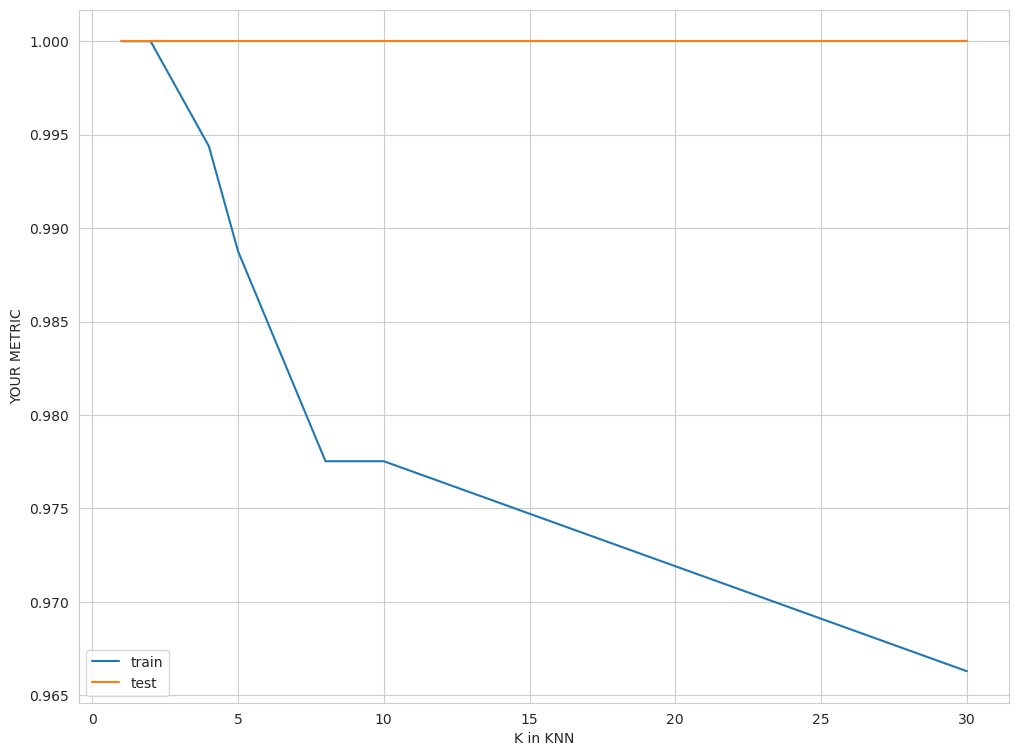

In [36]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Хмммм, такое чувство будто k=1 лучше всего, но понятно, что объект всегда будет соседом сам с собой. Ну значит k=3 возьмём, там ещё нормально всё работает...

### 1.5. Многоклассоввая классификация (2 балла)
Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [54]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier()
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
predictions

array(['1', '5', '7', '2', '0', '3', '1', '7', '6', '7', '0', '6', '9',
       '2', '0', '6', '8', '4', '9', '7', '9', '8', '1', '9', '9', '9',
       '4', '4', '0', '5', '0', '7', '3', '3', '2', '3', '6', '9', '3',
       '2', '0', '0', '8', '3', '2', '8', '4', '3', '1', '6', '9', '9',
       '2', '4', '5', '4', '1', '7', '4', '8', '5', '4', '1', '2', '7',
       '1', '9', '3', '7', '7', '6', '9', '6', '9', '7', '8', '0', '7',
       '2', '1', '5', '3', '8', '8', '9', '6', '3', '3', '6', '0', '3',
       '4', '5', '9', '6', '3', '7', '4', '6', '5'], dtype=object)

In [55]:
multiclass_accuracy(predictions, y_test)

0.8

## Задание 2. KNN на датасете diabetes (10 баллов)
Теперь попробуем применить KNN к задаче регрессии. Будем работать с данными о диабете. В этом задании будем использовать класс KNeighborsRegressor из библиотеки sklearn. Загрузим необходимые библиотеки:

In [58]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

In [59]:
X, y = load_diabetes(as_frame=True, return_X_y=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Column 11 is a quantitative measure of disease progression one year after baseline. Это я на сайте нашла, чем не EDA)))
А ещё я нашла, что эти данные уже стандартизованы, но я больше не знаю, что засунуть в пайплайн(

Пайплайн:

In [62]:
knn_pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=8, n_jobs=16))
])

In [63]:
knn_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsRegressor(n_jobs=16, n_neighbors=8))])

In [64]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


Ну самое умное, что пришло в голову, это посмотреть на корреляцию

<Axes: >

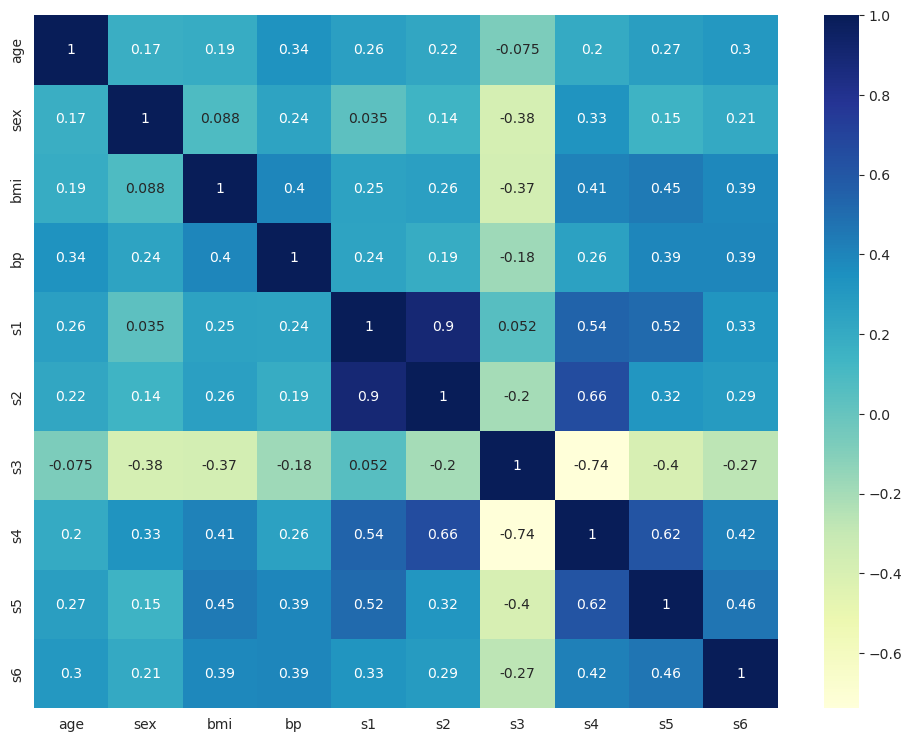

In [66]:
sns.heatmap(X.corr(), cmap="YlGnBu", annot=True)

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на тренировочных данных и сделайте предсказания.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    test_size=0.1)

In [69]:
knn_regr = KNeighborsRegressor(n_neighbors=8, n_jobs=16)
knn_regr.fit(X_train, y_train)
predictions = knn_regr.predict(X_test)
predictions

array([192.5  , 127.375, 164.   , 136.25 , 158.625, 198.875, 117.5  ,
        99.5  , 112.375,  78.375, 134.875, 218.625, 218.625, 225.125,
       188.125, 186.5  , 195.125, 137.375, 230.   ,  79.625,  96.   ,
       143.375, 119.75 , 208.25 ,  88.875, 102.875,  59.125, 130.25 ,
       199.25 , 123.25 , 134.   , 159.375, 143.   , 175.25 , 131.625,
       128.875,  86.875, 179.   , 161.875, 129.375, 167.875, 228.25 ,
       150.5  , 143.75 , 142.25 ])

### 2.3. Метрики регреcсии (3 балла)

In [71]:
r_squared(predictions, y_test), mae(predictions, y_test), mse(predictions, y_test)

(0.18532734293055664, 43.96666666666667, 3181.2166666666667)

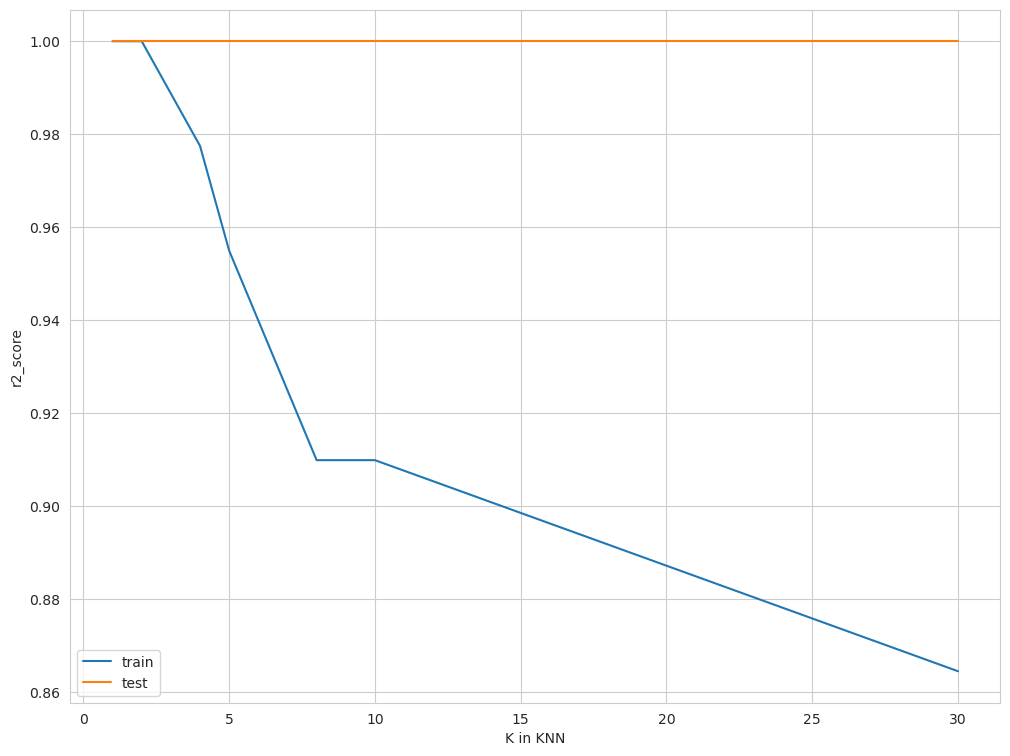

In [73]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train_bin, y_train_bin, X_test_bin, y_test_bin, params, r2_score)
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("r2_score");

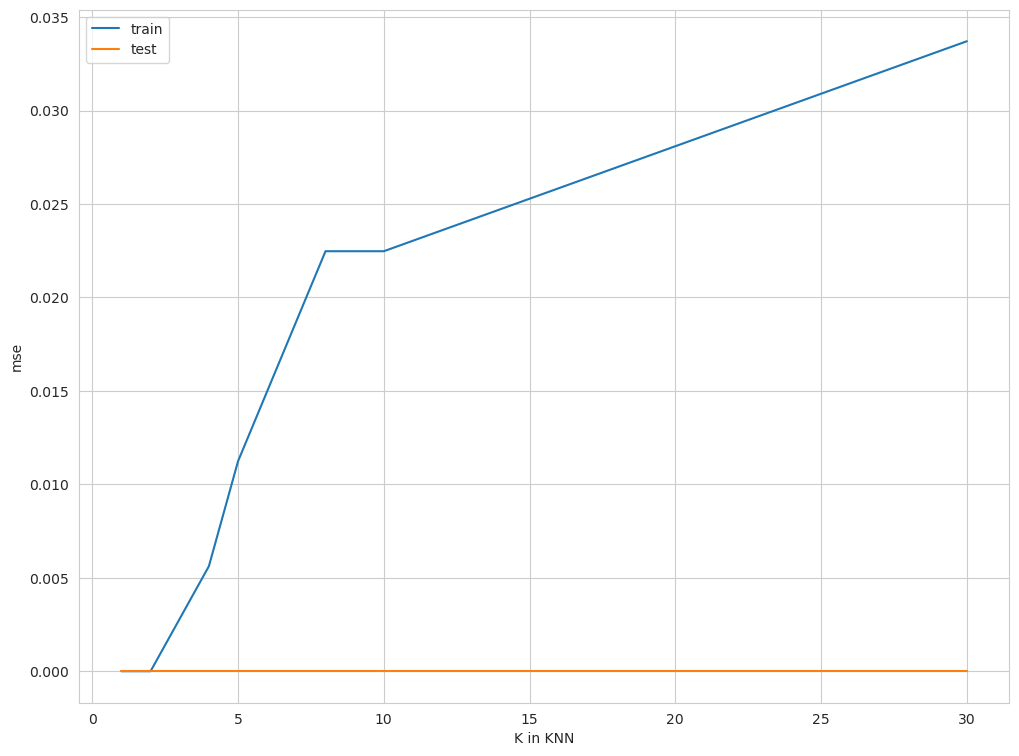

In [75]:
train_metrics, test_metrics = find_best_k(X_train_bin, y_train_bin, X_test_bin, y_test_bin, params, mse)
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("mse");

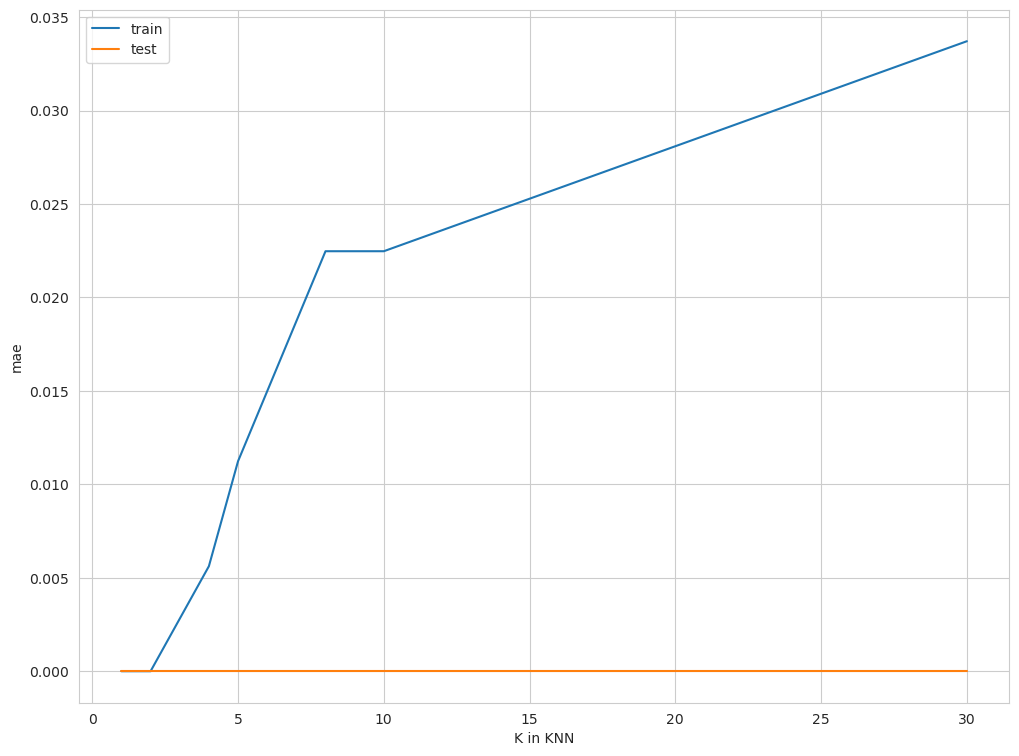

In [76]:
train_metrics, test_metrics = find_best_k(X_train_bin, y_train_bin, X_test_bin, y_test_bin, params, mae)
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("mae");

Я думаю, k=10 подойдёт

## Therapy time
**Ваши мысли:**

Мне было сложно, потому что подзабыла нумпай и приходилось гуглить прям простые вещи. Вообще задание ооооооочень объёмное, особенно первая часть